### Imports

In [1]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    import optuna
    import torch
    import os
    from datetime import datetime
    import random
    random.seed(3111)
    import h5py
    import matplotlib.pyplot as plt
    import numpy as np
    from torch.nn.functional import mse_loss
    from simulai.math.integration import LSODA, ClassWrapper, RK4
    from simulai.math.differentiation import CollocationDerivative
    from simulai.rom import POD
    from simulai.io import Reshaper
    from simulai.simulation import Pipeline
    from simulai.regression import OpInf
    import vtk
if os.path.split(os.getcwd())[-1] == "python":
    os.chdir(os.path.split(os.getcwd())[0]) # change directory

### Read data

In [2]:
datasetSize = "big" # choose dataset size
if datasetSize == "normal":
  datasetPath = ".\\dataset\\OpInfData.h5"
elif datasetSize == "big":
  # file of bigger dataset in desktop,
  # since it can't be uploaded to github
  datasetPath = os.environ["desktopPath"] + "\\vtkFiles\\OpInfData\\OpInfDataBig.h5"
# dataset with higher time resolution
with h5py.File(datasetPath, 'r') as f:
  # raw data is matrix with 'timestep' rows
  # and 'nodal pressure' columns.
  # original values
  # opInfData = np.array(f["OpInfData"], dtype = np.float32)[:-1]
  # values normalized in [0, 1]
  # opInfData = np.array(f["unitData"], dtype = np.float32)[:-1]
  # statistically standardized values
  opInfData = np.array(f["standardData"], dtype = np.float32)[:-1]
  # node coordinates is 2 x 'number of nodes' matrix.
  # first row is x; second, y
  nodeCoord = np.array(f["nodeCoords"], dtype = np.float32)
  # mesh connectivity of nodes
  nodeConn = np.array(f["nodeConnectivity"], dtype = np.int32) - 1

for var in [opInfData, nodeCoord, nodeConn]:
  print(type(var))
  print(var.shape)

<class 'numpy.ndarray'>
(10050, 3362)
<class 'numpy.ndarray'>
(2, 3362)
<class 'numpy.ndarray'>
(12672,)


### POD

Dimension reduction using Proper Orthogonal Decomposition

In [3]:
# Instantiating a Pipeline to prepare data
rom_config = {'n_components': 10} # new number of dimensions
pipeline = Pipeline(
  stages = [('data_preparer', Reshaper()),
  ('rom', POD(config = rom_config))]
)
# Executing the workflow
pipeline.exec(input_data = opInfData)
projectedData = pipeline.project_data(data = opInfData)
reconstructedData = pipeline.reconstruct_data(data = projectedData)
print(f"\nraw data shape: {opInfData.shape}")
print(f"projectedData shape: {projectedData.shape}")
print(f"reconstructedData shape: {reconstructedData.shape}")
print("Reconstruction MSE = {:.4e}".format(mse_loss(
    torch.tensor(reconstructedData), torch.tensor(opInfData)
).item()))

Executing a global pipeline.
Executed operation RESHAPER.
Relative contribution of the mean component: 0.00787135399878025
Relative Modal Energy 0.6488643288612366
Executed operation POD.
Applying the global reconstruction strategy.

raw data shape: (10050, 3362)
projectedData shape: (10050, 10)
reconstructedData shape: (10050, 3362)
Reconstruction MSE = 2.9273e-01


### Data split

In [4]:
# timesteps
if datasetSize == "normal":
  dt = 1.0 / 500 / 80
  timeRange = np.arange(0, 1005 * dt, dt)
elif datasetSize == "big":
  dt = 1.0 / 500 / 800
  timeRange = np.arange(0, 10050 * dt, dt)
# augment dataset with estimates of time derivatives
diff = CollocationDerivative(config = {})
derivativeData = diff.solve(data = projectedData, x = timeRange)
# split dataset
splitIndex = np.int32(len(timeRange) * 0.9)
dataTrain = projectedData[:splitIndex]
dataTest = projectedData[splitIndex:]
dataDerivativeTrain = derivativeData[:splitIndex]
dataDerivativeTest = derivativeData[splitIndex:]
timeTrain = timeRange[:splitIndex]
timeTest = timeRange[splitIndex:]

print(f"dataTrain shape: {dataTrain.shape}")
print(f"dataTest shape: {dataTest.shape}")
print(f"dataDerivativeTrain shape: {dataDerivativeTrain.shape}")
print(f"dataDerivativeTest shape: {dataDerivativeTest.shape}")
print(f"timeTrain shape: {timeTrain.shape}")
print(f"timeTest shape: {timeTest.shape}")

Performing Collocation Derivation.
dataTrain shape: (9045, 10)
dataTest shape: (1005, 10)
dataDerivativeTrain shape: (9045, 10)
dataDerivativeTest shape: (1005, 10)
timeTrain shape: (9045,)
timeTest shape: (1005,)


### Best parameters
Hyperparameter optimization with the Optuna package to find the optimal combination of regularization weights.

In [5]:
# objective is a function which returns a scalar
# that must be minimized
def objective(trial):
    print("")
    # setup optimization parameters (regularization weights)
    lambdaLinear = trial.suggest_float('lambdaLinear', 0, 1e3, step = 50)
    lambdaQuad = trial.suggest_float('lambdaQuad', 0, 1e3, step = 50)
    # OpInf least squares minimization in embedded space
    _opInfObject = OpInf(bias_rescale = 1e-15, solver = 'lstsq')
    _opInfObject.set(lambda_linear = lambdaLinear, lambda_quadratic = lambdaQuad)
    _opInfObject.fit(input_data = dataTrain, target_data = dataDerivativeTrain)
    # Time integration through test time interval
    _opInfObject.construct_K_op()
    _rightOperator = ClassWrapper(_opInfObject)
    _solver = LSODA(_rightOperator)
    _testIntegration = _solver.run(dataTrain[-1], timeTest)
    # return MSE of time integration in test split
    print("")
    return np.square(np.subtract(_testIntegration, dataTest)).mean()
# create study object with desired sampler
study = optuna.create_study(
    sampler = optuna.samplers.RandomSampler()
    # sampler = optuna.samplers.CmaEsSampler()
    # sampler = optuna.samplers.QMCSampler()
)
# run optimization
study.optimize(objective, n_trials = 100, show_progress_bar = True)
# results
print(f"\nBest Parameters: {study.best_params}")
print(f"Best objective value: {study.best_value}")

[I 2023-07-07 16:25:06,133] A new study created in memory with name: no-name-3fe283b0-1264-4769-85d2-83776fc0cbcd
Best trial: 1. Best value: 12.7553:   1%|          | 1/100 [00:00<00:08, 11.26it/s]


Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:06,188] Trial 0 finished with value: 65.97727143673015 and parameters: {'lambdaLinear': 600.0, 'lambdaQuad': 250.0}. Best is trial 0 with value: 65.97727143673015.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:06,221] Trial 1 finished with value: 12.755275654274769 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 0.0}. Best is trial 1 with value: 12.755275654274769.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



Best trial: 1. Best value: 12.7553:   3%|▎         | 3/100 [00:00<00:04, 24.16it/s]

[I 2023-07-07 16:25:06,257] Trial 2 finished with value: 584.8891918798838 and parameters: {'lambdaLinear': 600.0, 'lambdaQuad': 800.0}. Best is trial 1 with value: 12.755275654274769.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



Best trial: 1. Best value: 12.7553:   3%|▎         | 3/100 [00:00<00:04, 24.16it/s]

[I 2023-07-07 16:25:06,286] Trial 3 finished with value: 487.2214206820958 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 850.0}. Best is trial 1 with value: 12.755275654274769.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


c:\Users\kaoid\.virtualenvs\acousticPINNs-v9ZJkn9d\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Best trial: 5. Best value: 9.8218:   6%|▌         | 6/100 [00:00<00:04, 22.76it/s] 


[I 2023-07-07 16:25:06,365] Trial 4 finished with value: 7.467628725954023e+27 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 300.0}. Best is trial 1 with value: 12.755275654274769.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:06,395] Trial 5 finished with value: 9.82180370137066 and parameters: {'lambdaLinear': 50.0, 'lambdaQuad': 0.0}. Best is trial 5 with value: 9.82180370137066.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:06,423] Trial 6 finished with value: 510.31208399036075 and parameters: {'lambdaLinear': 500.0, 'lambdaQuad': 500.0}. Best is trial 5 with value: 9.82180370137066.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



Best trial: 5. Best value: 9.8218:   7%|▋         | 7/100 [00:00<00:04, 22.76it/s]

[I 2023-07-07 16:25:06,450] Trial 7 finished with value: 565.367236574141 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 800.0}. Best is trial 5 with value: 9.82180370137066.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



Best trial: 5. Best value: 9.8218:  10%|█         | 10/100 [00:00<00:03, 27.74it/s]

[I 2023-07-07 16:25:06,481] Trial 8 finished with value: 491.04518751974103 and parameters: {'lambdaLinear': 850.0, 'lambdaQuad': 500.0}. Best is trial 5 with value: 9.82180370137066.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:06,511] Trial 9 finished with value: 974.4469026974646 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 550.0}. Best is trial 5 with value: 9.82180370137066.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:06,533] Trial 10 finished with value: 20.957015072287195 and parameters: {'lambdaLinear': 500.0, 'lambdaQuad': 150.0}. Best is trial 5 with value: 9.82180370137066.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



Best trial: 5. Best value: 9.8218:  15%|█▌        | 15/100 [00:00<00:02, 33.56it/s]

[I 2023-07-07 16:25:06,559] Trial 11 finished with value: 14.74394787220457 and parameters: {'lambdaLinear': 700.0, 'lambdaQuad': 0.0}. Best is trial 5 with value: 9.82180370137066.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:06,582] Trial 12 finished with value: 50.96460724842897 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 200.0}. Best is trial 5 with value: 9.82180370137066.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:06,603] Trial 13 finished with value: 20.962808638892614 and parameters: {'lambdaLinear': 650.0, 'lambdaQuad': 150.0}. Best is trial 5 with value: 9.82180370137066.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:06,626] Trial 14 finished with value: 112.75062267012362 and parameters: {'lambdaLinear': 800.0, 'lambdaQuad': 350.0}. Best is trial 5 with value: 9.8218037013706

Best trial: 5. Best value: 9.8218:  15%|█▌        | 15/100 [00:00<00:02, 33.56it/s]

[I 2023-07-07 16:25:06,652] Trial 15 finished with value: 85.88593453002807 and parameters: {'lambdaLinear': 600.0, 'lambdaQuad': 300.0}. Best is trial 5 with value: 9.82180370137066.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 5. Best value: 9.8218:  16%|█▌        | 16/100 [00:00<00:02, 33.56it/s]


[I 2023-07-07 16:25:06,725] Trial 16 finished with value: 7.467628726006215e+27 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 300.0}. Best is trial 5 with value: 9.82180370137066.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



Best trial: 5. Best value: 9.8218:  20%|██        | 20/100 [00:00<00:02, 30.59it/s]

[I 2023-07-07 16:25:06,753] Trial 17 finished with value: 462.73243050341154 and parameters: {'lambdaLinear': 250.0, 'lambdaQuad': 900.0}. Best is trial 5 with value: 9.82180370137066.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:06,779] Trial 18 finished with value: 354.98560078767497 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 1000.0}. Best is trial 5 with value: 9.82180370137066.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:06,809] Trial 19 finished with value: 922.674731903406 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 600.0}. Best is trial 5 with value: 9.82180370137066.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:06,830] Trial 20 finished with value: 20.96400551050855 and parameters: {'lambdaLinear': 700.0, 'lambdaQuad': 150.0}. Best is trial 5 with value: 9.82180370137

Best trial: 22. Best value: 2.93768:  23%|██▎       | 23/100 [00:00<00:02, 33.11it/s]

[I 2023-07-07 16:25:06,859] Trial 21 finished with value: 658.8255250964258 and parameters: {'lambdaLinear': 600.0, 'lambdaQuad': 700.0}. Best is trial 5 with value: 9.82180370137066.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:06,879] Trial 22 finished with value: 2.9376834041662483 and parameters: {'lambdaLinear': 900.0, 'lambdaQuad': 100.0}. Best is trial 22 with value: 2.9376834041662483.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



Best trial: 22. Best value: 2.93768:  23%|██▎       | 23/100 [00:00<00:02, 33.11it/s]

[I 2023-07-07 16:25:06,906] Trial 23 finished with value: 532.5679520774353 and parameters: {'lambdaLinear': 800.0, 'lambdaQuad': 850.0}. Best is trial 22 with value: 2.9376834041662483.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



Best trial: 26. Best value: 0.795637:  27%|██▋       | 27/100 [00:00<00:02, 30.52it/s]

[I 2023-07-07 16:25:06,935] Trial 24 finished with value: 718.9932048362299 and parameters: {'lambdaLinear': 50.0, 'lambdaQuad': 600.0}. Best is trial 22 with value: 2.9376834041662483.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:07,010] Trial 25 finished with value: 7.373833337842086e+26 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 550.0}. Best is trial 22 with value: 2.9376834041662483.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:07,032] Trial 26 finished with value: 0.7956370135843978 and parameters: {'lambdaLinear': 800.0, 'lambdaQuad': 50.0}. Best is trial 26 with value: 0.7956370135843978.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



Best trial: 26. Best value: 0.795637:  27%|██▋       | 27/100 [00:00<00:02, 30.52it/s]

[I 2023-07-07 16:25:07,059] Trial 27 finished with value: 112.56076991423964 and parameters: {'lambdaLinear': 850.0, 'lambdaQuad': 350.0}. Best is trial 26 with value: 0.7956370135843978.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



[I 2023-07-07 16:25:07,090] Trial 28 finished with value: 587.1606268501024 and parameters: {'lambdaLinear': 500.0, 'lambdaQuad': 800.0}. Best is trial 26 with value: 0.7956370135843978.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



Best trial: 32. Best value: 0.794776:  33%|███▎      | 33/100 [00:01<00:02, 31.77it/s]

[I 2023-07-07 16:25:07,117] Trial 29 finished with value: 421.7230140321296 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 950.0}. Best is trial 26 with value: 0.7956370135843978.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:07,147] Trial 30 finished with value: 668.7726886939557 and parameters: {'lambdaLinear': 750.0, 'lambdaQuad': 650.0}. Best is trial 26 with value: 0.7956370135843978.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:07,178] Trial 31 finished with value: 420.4788140978724 and parameters: {'lambdaLinear': 500.0, 'lambdaQuad': 950.0}. Best is trial 26 with value: 0.7956370135843978.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:07,199] Trial 32 finished with value: 0.7947761296726171 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 50.0}. Best is trial 32 with value: 0.794

Best trial: 32. Best value: 0.794776:  35%|███▌      | 35/100 [00:01<00:01, 33.86it/s]

[I 2023-07-07 16:25:07,247] Trial 34 finished with value: 2.8878163297885666 and parameters: {'lambdaLinear': 200.0, 'lambdaQuad': 100.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



Best trial: 32. Best value: 0.794776:  35%|███▌      | 35/100 [00:01<00:01, 33.86it/s]

[I 2023-07-07 16:25:07,277] Trial 35 finished with value: 668.7726886939557 and parameters: {'lambdaLinear': 750.0, 'lambdaQuad': 650.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



Best trial: 32. Best value: 0.794776:  40%|████      | 40/100 [00:01<00:01, 34.46it/s]

[I 2023-07-07 16:25:07,307] Trial 36 finished with value: 667.3883262178059 and parameters: {'lambdaLinear': 800.0, 'lambdaQuad': 650.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:07,330] Trial 37 finished with value: 86.27075478874012 and parameters: {'lambdaLinear': 500.0, 'lambdaQuad': 300.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:07,360] Trial 38 finished with value: 478.60199933097135 and parameters: {'lambdaLinear': 950.0, 'lambdaQuad': 900.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:07,387] Trial 39 finished with value: 214.54419011018604 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 400.0}. Best is trial 32 with value: 0.7

Best trial: 32. Best value: 0.794776:  41%|████      | 41/100 [00:01<00:01, 34.46it/s]

[I 2023-07-07 16:25:07,446] Trial 41 finished with value: 14.602688255808268 and parameters: {'lambdaLinear': 500.0, 'lambdaQuad': 0.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



Best trial: 32. Best value: 0.794776:  43%|████▎     | 43/100 [00:01<00:01, 34.87it/s]

[I 2023-07-07 16:25:07,471] Trial 42 finished with value: 326.26174178817325 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 1000.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



Best trial: 32. Best value: 0.794776:  48%|████▊     | 48/100 [00:01<00:01, 35.79it/s]

[I 2023-07-07 16:25:07,498] Trial 43 finished with value: 656.97540230916 and parameters: {'lambdaLinear': 650.0, 'lambdaQuad': 700.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:07,519] Trial 44 finished with value: 20.959437070133436 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 150.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:07,549] Trial 45 finished with value: 603.7661309811766 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 550.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:07,576] Trial 46 finished with value: 487.2214206820958 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 850.0}. Best is trial 32 with value: 0.7947

Best trial: 32. Best value: 0.794776:  49%|████▉     | 49/100 [00:01<00:01, 35.79it/s]

[I 2023-07-07 16:25:07,654] Trial 49 finished with value: 65.91029922882915 and parameters: {'lambdaLinear': 650.0, 'lambdaQuad': 250.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



Best trial: 32. Best value: 0.794776:  55%|█████▌    | 55/100 [00:01<00:01, 36.40it/s]

[I 2023-07-07 16:25:07,681] Trial 50 finished with value: 191.02026898705168 and parameters: {'lambdaLinear': 750.0, 'lambdaQuad': 400.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:07,710] Trial 51 finished with value: 386.46750346790674 and parameters: {'lambdaLinear': 200.0, 'lambdaQuad': 950.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:07,740] Trial 52 finished with value: 632.101367710585 and parameters: {'lambdaLinear': 200.0, 'lambdaQuad': 500.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:07,767] Trial 53 finished with value: 587.483892232646 and parameters: {'lambdaLinear': 950.0, 'lambdaQuad': 550.0}. Best is trial 32 with value: 0.794

Best trial: 32. Best value: 0.794776:  56%|█████▌    | 56/100 [00:01<00:01, 36.40it/s]

[I 2023-07-07 16:25:07,844] Trial 56 finished with value: 922.674731903406 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 600.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



Best trial: 32. Best value: 0.794776:  63%|██████▎   | 63/100 [00:01<00:01, 36.79it/s]

[I 2023-07-07 16:25:07,871] Trial 57 finished with value: 425.0767704190217 and parameters: {'lambdaLinear': 850.0, 'lambdaQuad': 950.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:07,892] Trial 58 finished with value: 0.7955313084971937 and parameters: {'lambdaLinear': 650.0, 'lambdaQuad': 50.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:07,923] Trial 59 finished with value: 664.2736296162541 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 600.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:07,953] Trial 60 finished with value: 687.3391859458396 and parameters: {'lambdaLinear': 400.0, 'lambdaQuad': 600.0}. Best is trial 32 with value: 0.794

Best trial: 32. Best value: 0.794776:  63%|██████▎   | 63/100 [00:01<00:01, 36.79it/s]

[I 2023-07-07 16:25:08,033] Trial 63 finished with value: 584.0740652189406 and parameters: {'lambdaLinear': 650.0, 'lambdaQuad': 800.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



[I 2023-07-07 16:25:08,056] Trial 64 finished with value: 46.36950725735455 and parameters: {'lambdaLinear': 600.0, 'lambdaQuad': 200.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:08,083] Trial 65 finished with value: 85.50483040489111 and parameters: {'lambdaLinear': 800.0, 'lambdaQuad': 300.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:08,103] Trial 66 finished with value: 0.7954082007125136 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 50.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:08,124] Trial 67 finished with value: 20.943711839917295 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 150.0}. Best is trial 32 with value: 0.79

Best trial: 32. Best value: 0.794776:  71%|███████   | 71/100 [00:02<00:00, 38.43it/s]

[I 2023-07-07 16:25:08,211] Trial 70 finished with value: 538.3840970000825 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 500.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:08,241] Trial 71 finished with value: 516.9017008561422 and parameters: {'lambdaLinear': 450.0, 'lambdaQuad': 500.0}. Best is trial 32 with value: 0.7947761296726171.


Best trial: 32. Best value: 0.794776:  74%|███████▍  | 74/100 [00:02<00:00, 37.14it/s]


Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:08,321] Trial 72 finished with value: 1.0037408144252074e+30 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 400.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:08,347] Trial 73 finished with value: 339.7221491948624 and parameters: {'lambdaLinear': 800.0, 'lambdaQuad': 450.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:08,375] Trial 74 finished with value: 703.6633499209538 and parameters: {'lambdaLinear': 250.0, 'lambdaQuad': 700.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



Best trial: 32. Best value: 0.794776:  76%|███████▌  | 76/100 [00:02<00:00, 31.87it/s]

[I 2023-07-07 16:25:08,411] Trial 75 finished with value: 721.616142943496 and parameters: {'lambdaLinear': 300.0, 'lambdaQuad': 650.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 32. Best value: 0.794776:  80%|████████  | 80/100 [00:02<00:00, 31.78it/s]


[I 2023-07-07 16:25:08,451] Trial 76 finished with value: 78.88700768817968 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 250.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:08,482] Trial 77 finished with value: 85.4490113425502 and parameters: {'lambdaLinear': 850.0, 'lambdaQuad': 300.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:08,506] Trial 78 finished with value: 14.133956686392356 and parameters: {'lambdaLinear': 300.0, 'lambdaQuad': 0.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:08,537] Trial 79 finished with value: 826.4542347156481 and parameters: {'lambdaLinear': 200.0, 'lambdaQuad': 600.0}. Best is trial 32 with value: 0.7947

Best trial: 32. Best value: 0.794776:  82%|████████▏ | 82/100 [00:02<00:00, 31.78it/s]

[I 2023-07-07 16:25:08,595] Trial 81 finished with value: 86.05199336397862 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 300.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:08,623] Trial 82 finished with value: 478.4416645326623 and parameters: {'lambdaLinear': 850.0, 'lambdaQuad': 900.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



Best trial: 32. Best value: 0.794776:  86%|████████▌ | 86/100 [00:02<00:00, 32.55it/s]

[I 2023-07-07 16:25:08,652] Trial 83 finished with value: 46.2752219926955 and parameters: {'lambdaLinear': 950.0, 'lambdaQuad': 200.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:08,695] Trial 84 finished with value: 738.7133721132933 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 700.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:08,730] Trial 85 finished with value: 326.26174178817325 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 1000.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:08,753] Trial 86 finished with value: 20.943711839917295 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 150.0}. Best is trial 32 with value: 0.7

Best trial: 32. Best value: 0.794776:  88%|████████▊ | 88/100 [00:02<00:00, 32.27it/s]

[I 2023-07-07 16:25:08,781] Trial 87 finished with value: 190.23163310780353 and parameters: {'lambdaLinear': 800.0, 'lambdaQuad': 400.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:08,811] Trial 88 finished with value: 646.9250781612742 and parameters: {'lambdaLinear': 950.0, 'lambdaQuad': 600.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



Best trial: 32. Best value: 0.794776:  92%|█████████▏| 92/100 [00:02<00:00, 29.36it/s]

[I 2023-07-07 16:25:08,836] Trial 89 finished with value: 65.81403250498752 and parameters: {'lambdaLinear': 750.0, 'lambdaQuad': 250.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:08,915] Trial 90 finished with value: 1.6241884171304484e+27 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 600.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:08,946] Trial 91 finished with value: 738.7133721132933 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 700.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 32. Best value: 0.794776:  92%|█████████▏| 92/100 [00:02<00:00, 29.36it/s]


[I 2023-07-07 16:25:09,020] Trial 92 finished with value: 7.373833337842086e+26 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 550.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.


Best trial: 32. Best value: 0.794776: 100%|██████████| 100/100 [00:03<00:00, 32.69it/s]

Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:09,042] Trial 93 finished with value: 46.30095752190629 and parameters: {'lambdaLinear': 800.0, 'lambdaQuad': 200.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:09,068] Trial 94 finished with value: 532.2111098715102 and parameters: {'lambdaLinear': 950.0, 'lambdaQuad': 850.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:09,096] Trial 95 finished with value: 14.319974235184041 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 0.0}. Best is trial 32 with value: 0.7947761296726171.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.

[I 2023-07-07 16:25:09,123] Trial 96 finished with value: 47.560440636374025 and parameters: {'lambdaLinear': 200.0, 'l

Experiments were conducted to choose between the samplers RandomSampler, CmaEsSampler and QMCSampler (1h, 90 trials each). Random sampler achieved the smallest test interval MSE.

### OpInf fitting
OpInf least squares minimization in projected space. Find optimal coefficients of quadratic system of ODEs in projected space.

In [6]:
# create OpInf object
opInfObject = OpInf(bias_rescale = 1e-15, solver = 'lstsq')
# set optimal regularization weights from previous step
opInfObject.set(
    lambda_linear = study.best_params["lambdaLinear"],
    # lambda_linear = 1000,
    lambda_quadratic = 0
    # lambda_quadratic = 650
)
# least squares fit
opInfObject.fit(input_data = dataTrain, target_data = dataDerivativeTrain)

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


### Time integration
Integrate in time the ODE system approximated in the previous code cell. Start in the last time step of the training split, and integrate through the test split

In [7]:
opInfObject.construct_K_op()
rightOperator = ClassWrapper(opInfObject)
solver = LSODA(rightOperator)
testIntegration = solver.run(dataTrain[-1], timeTest)
# output is matrix with 'test time steps' rows and
# 'embedded dimensions' columns. Represents field evolution
# throughout time steps in test split (in projected space)
print(f"testIntegration shape: {testIntegration.shape}")
# After time integration, return to original high dimensional space
reconstructIntTest = pipeline.reconstruct_data(data = testIntegration)
print(f"reconstructIntTest shape: {reconstructIntTest.shape}")

testIntegration shape: (1005, 10)
Applying the global reconstruction strategy.
reconstructIntTest shape: (1005, 3362)


### Model error

In [8]:
# MSE of time integration over test split in embedded space
mseLowDim = mse_loss(torch.tensor(testIntegration), torch.tensor(dataTest))
print("Reduced order MSE = {:.4e}".format(mseLowDim.item()))
# MSE of time integration over test split in original space
mseHighDim = mse_loss(torch.tensor(reconstructIntTest), torch.tensor(opInfData[splitIndex:]))
print("Full order MSE = {:.4e}".format(mseHighDim.item()))

Reduced order MSE = 1.4320e+01
Full order MSE = 5.7536e-02


### Integration error history
Sample some positions and plot their time integration error histories

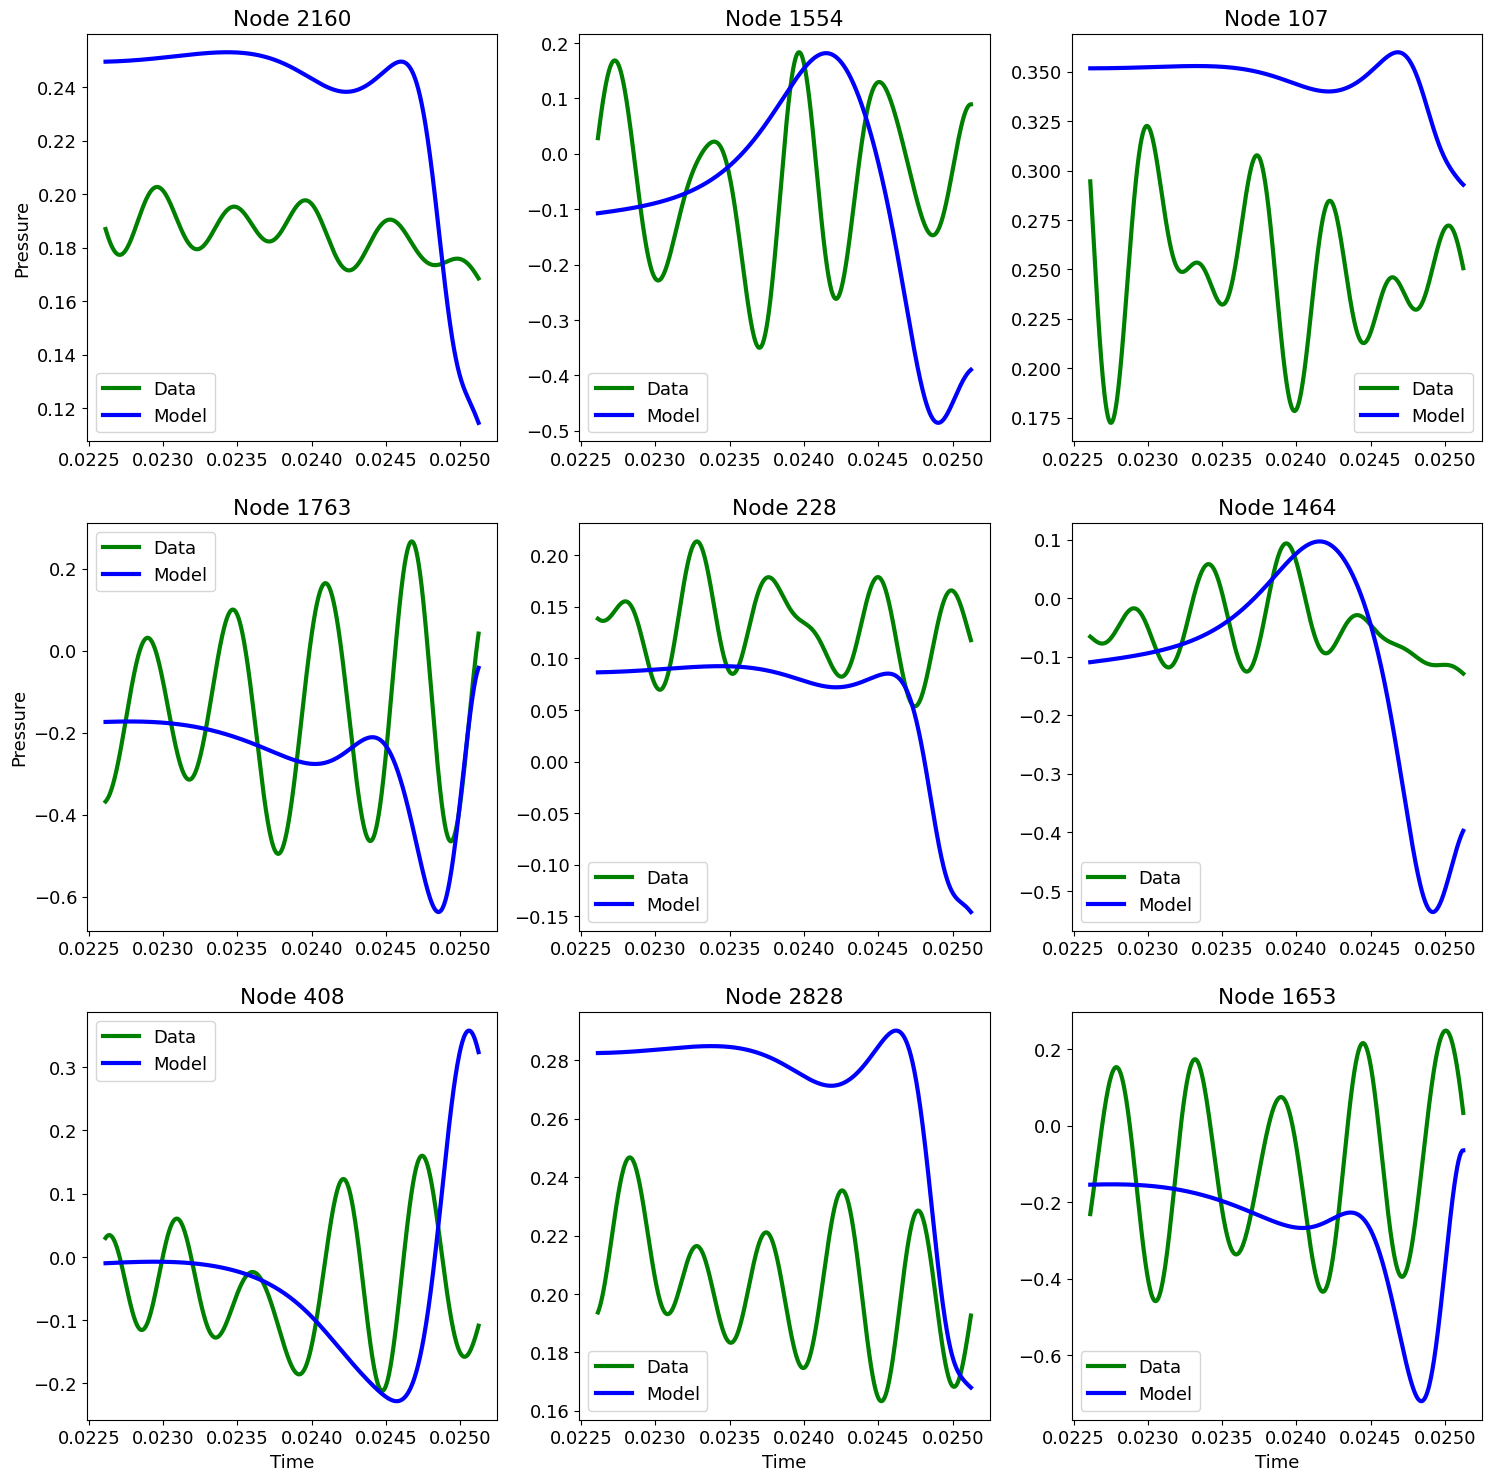

In [9]:
plt.rcParams['font.size'] = 13
# choose random points in physical domain
points = random.sample(range(opInfData.shape[1]), k = 9)
# create figure. 'ax' is (3, 3) array of Axes
fig, ax = plt.subplots(3, 3, figsize = (18, 18))
# iterate in subplots
for (plotID, (axis, point)) in enumerate(zip(ax.flatten(), points)):
  axis.plot(timeTest, opInfData[-timeTest.shape[0]:, point],
    label = "Data", color = 'green', linewidth = 3
  )
  axis.plot(timeTest, reconstructIntTest[-timeTest.shape[0]:, point],
    label = "Model", color = 'blue', linewidth = 3
  )
  axis.set_title(f"Node {point}")
  axis.legend()
  if plotID in [6, 7, 8]:
    axis.set_xlabel("Time")
  elif plotID in [0, 3, 6]:
    axis.set_ylabel("Pressure")

### Reconstruction error
Sample some points and plot their reconstruction error histories in the train split

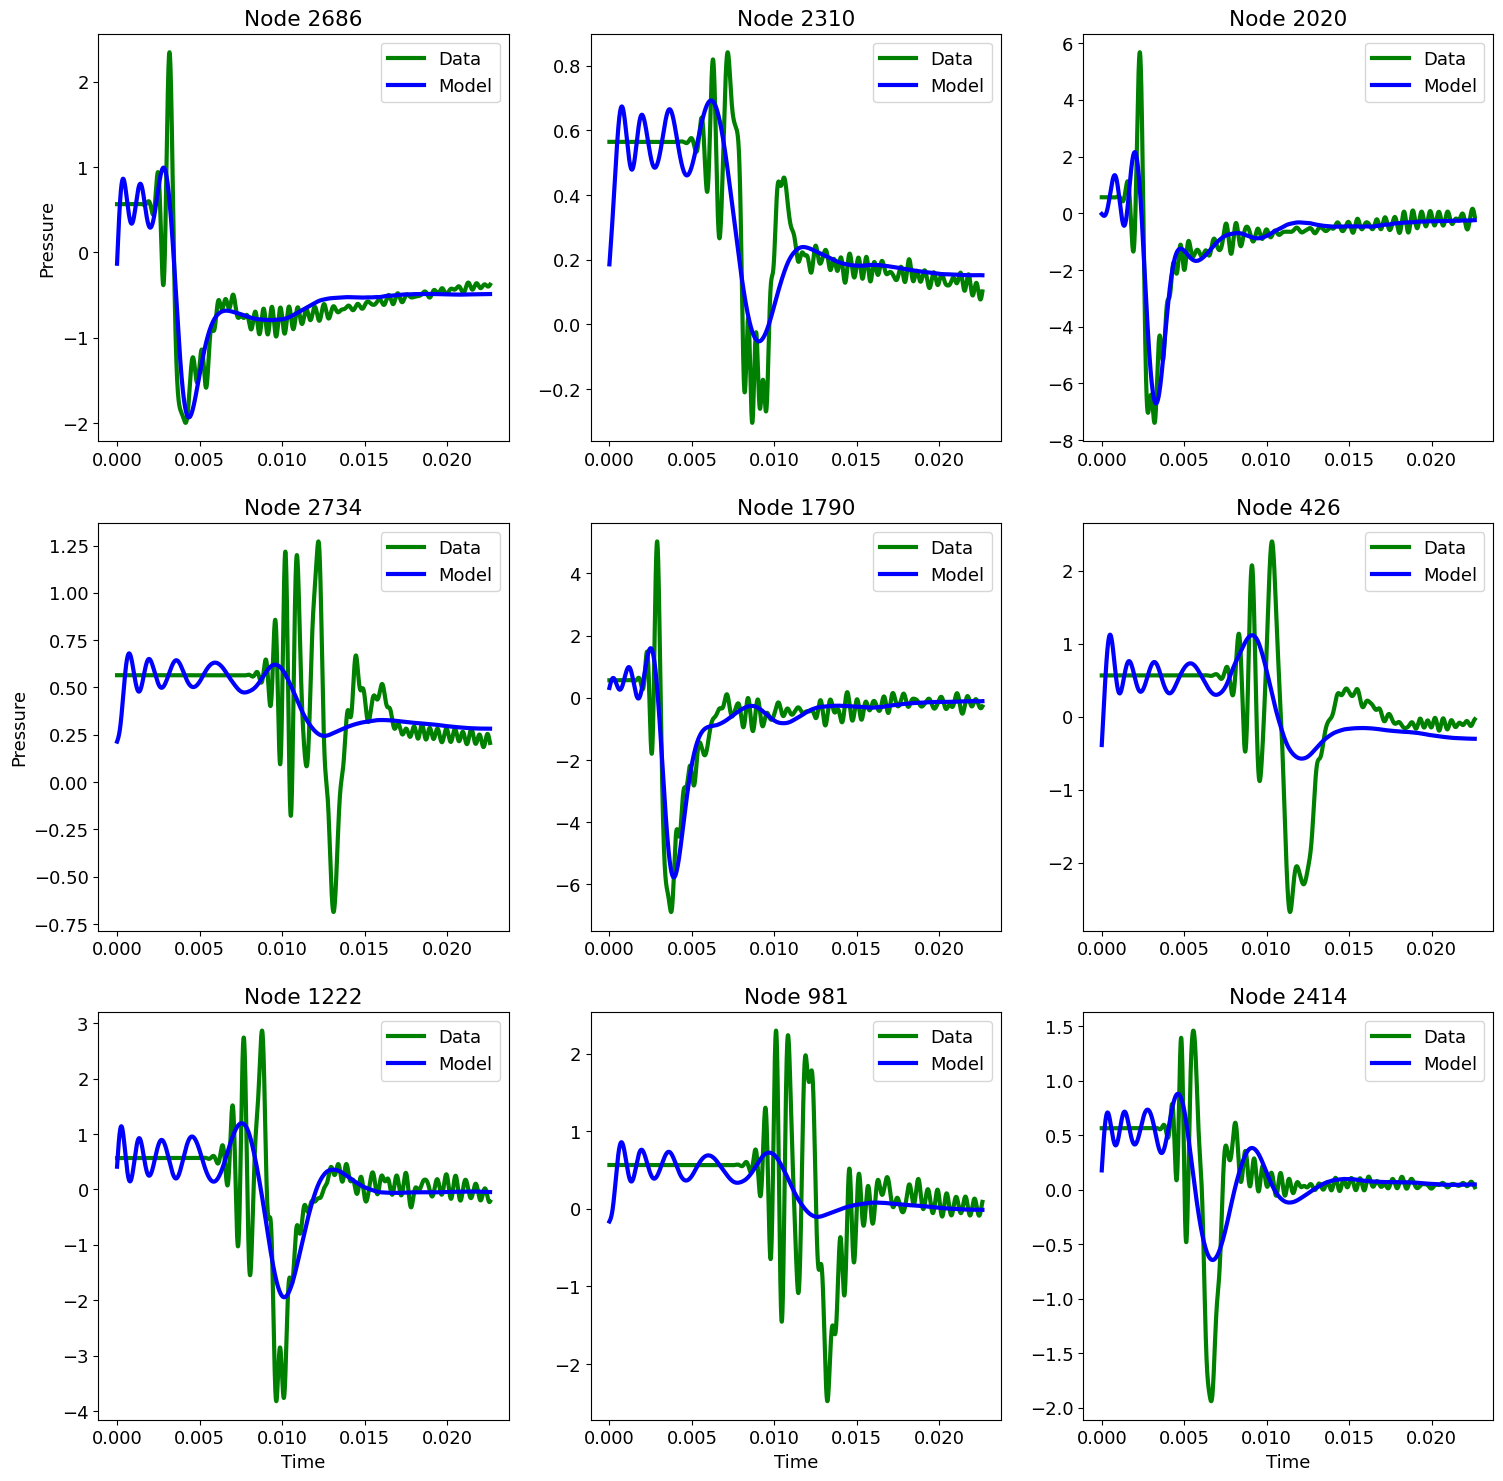

In [10]:
# choose random points in physical domain
points = random.sample(range(opInfData.shape[1]), k = 9)
# create figure. 'ax' is (3, 3) array of Axes
fig, ax = plt.subplots(3, 3, figsize = (18, 18))
# iterate in subplots
for (plotID, (axis, point)) in enumerate(zip(ax.flatten(), points)):
  axis.plot(timeTrain, opInfData[:timeTrain.shape[0]:, point],
    label = "Data", color = 'green', linewidth = 3
  )
  axis.plot(timeTrain, reconstructedData[:timeTrain.shape[0]:, point],
    label = "Model", color = 'blue', linewidth = 3
  )
  axis.set_title(f"Node {point}")
  axis.legend()
  if plotID in [6, 7, 8]:
    axis.set_xlabel("Time")
  elif plotID in [0, 3, 6]:
    axis.set_ylabel("Pressure")

### Animation

In [11]:
# create folder for vtu files
folderName = f"""{datetime.now().strftime("%d-%H-%M-%S")}"""
print(f"""{datetime.now().strftime("%H-%M-%S")}""")
os.mkdir(os.environ["desktopPath"] + f"\\vtkFiles\\animation\\OpInfAnimation\\{folderName}")
# iterate in time steps
for step in range(reconstructIntTest.shape[0]):
    # create vtk object
    my_vtk_dataset = vtk.vtkUnstructuredGrid()
    # create points by defining coordinates
    points = vtk.vtkPoints()
    for id in range(reconstructIntTest.shape[1]):
        points.InsertPoint(id, [nodeCoord[0, id], nodeCoord[1, id], 0])
    my_vtk_dataset.SetPoints(points)
    # create elements by establishing connectivity
    numberOfElements = 3168
    my_vtk_dataset.Allocate(numberOfElements)
    for eleID in range(numberOfElements):
        my_vtk_dataset.InsertNextCell(
            vtk.VTK_QUAD, 4,
            np.array(nodeConn[4 * eleID : 4 * (eleID + 1)])
        )
    # create data arrays
    array = vtk.vtkDoubleArray()
    array.SetNumberOfComponents(1)
    array.SetNumberOfTuples(reconstructIntTest.shape[1])
    array.SetName('pressure')
    # set values in all nodes for current time step
    for id in range(reconstructIntTest.shape[1]):
        array.SetTuple(id, [reconstructIntTest[step, id]])
    my_vtk_dataset.GetPointData().AddArray(array)
    # save data to disk
    writer = vtk.vtkXMLUnstructuredGridWriter()
    writer.SetFileName(
        os.environ["desktopPath"] + f"\\vtkFiles\\animation\\OpInfAnimation\\{folderName}\\output-{step}.vtu"
    )
    writer.SetInputData(my_vtk_dataset)
    writer.Write();

16-25-12
